In [1]:
%%capture
try:
  import pygraphviz as pgy
except:
  !apt install libgraphviz-dev
  !pip install pygraphviz

--2022-02-13 08:26:43--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTJ6sLtvjXCKjGxtmkV3FqxWk3O9WwSuvCE1g
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 74.125.203.102, 74.125.203.100, 74.125.203.101, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|74.125.203.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5352 (5.2K) [image/jpeg]
Saving to: ‘CoP.jpg’

CoP.jpg             100%[===================>]   5.23K  --.-KB/s    in 0s      

2022-02-13 08:26:43 (58.3 MB/s) - ‘CoP.jpg’ saved [5352/5352]



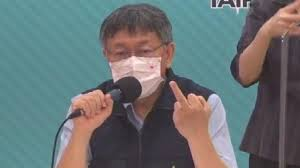

In [2]:
#@title 設定圖片
import cv2
from google.colab.patches import cv2_imshow
cv2.imshow = cv2_imshow
import numpy as np
from copy import copy

choose = 'CoP' #@param ['CoP', 'Fish', 'Veg']

image = {
  'CoP':['CoP.jpg','https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTJ6sLtvjXCKjGxtmkV3FqxWk3O9WwSuvCE1g&usqp=CAU'],
  'Fish':['Fish.jpg','https://d32kak7w9u5ewj.cloudfront.net/media/image/2018/11/2e6888eb9fb4481d936af71854b55f66.jpg'],
  'Veg':['Veg.jpg','https://gdb.voanews.com/DD9EFE8A-F787-4FB1-B0DC-39E627C2DB04_w408_r1_s.jpg']
}
!wget -O {image[choose][0]} {image[choose][1]}
img = cv2.imread(image[choose][0])
cv2_imshow(img)

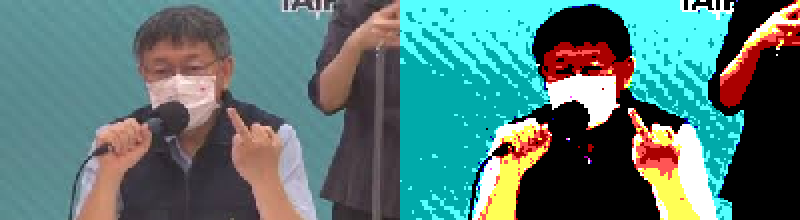

In [3]:
#@title Subsampling & Quantization
differential_coding = True #@param {type:"boolean"}

palette = np.array([
  [0,0,0],
  [170,0,0],
  [0,170,0],
  [170,170,0],
  [0,0,170],
  [170,0,170],
  [0,170,170], #[0,85,170],
  [170,170,170],
  [85,85,85],
  [255,85,85],
  [85,255,85],
  [255,255,85],
  [85,85,255],
  [255,85,255],
  [85,255,255],
  [255,255,255],
])

def C256toC16(img):
  img = copy(img)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i,j,:].mean()>128:
        for k in range(3):
          img[i,j,k] = 255 if img[i,j,k]>127 else 85
      else:
        for k in range(3):
          img[i,j,k] = 170 if img[i,j,k]>127 else 0
  return img

def C256to8086(img):
  last_pixel = 0
  img = copy(img)
  img2 = np.zeros(shape=img.shape[:2],dtype=int)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if differential_coding:
        this_pixel = np.where(np.all((palette==img[i,j,:]),axis=1))[0][0]
        img2[i,j] = this_pixel - last_pixel + 16
        last_pixel = this_pixel
      else:
        img2[i,j] = np.where(np.all((palette==img[i,j,:]),axis=1))[0][0]
  return img2

def _8086toC16(img):
  return palette[img]

def show(img_list):
  for i in range(len(img_list)):
    img_list[i] = cv2.resize(img_list[i], (400,220), interpolation=cv2.INTER_NEAREST)
  for i in range(0,len(img_list),2):
    if i==len(img_list)-1:
      cv2.imshow(img_list[i])
    else:
      cv2.imshow(np.hstack([img_list[i],img_list[i+1]]))


img2 = cv2.resize(img, (200,110), interpolation=cv2.INTER_NEAREST)
img3 = C256toC16(img2)
img4 = C256to8086(img3)

show([img2,img3])

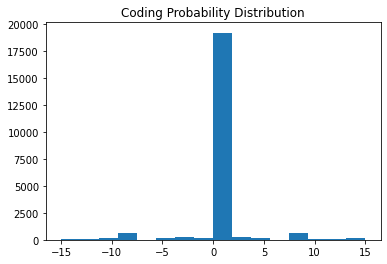

In [4]:
#@title 編碼機率分布
import matplotlib.pyplot as plt
if differential_coding:
  plt.hist((img4-16).flatten(),bins=16)  
else:
  plt.hist(img4.flatten(),bins=31)
plt.title('Coding Probability Distribution')
plt.show()

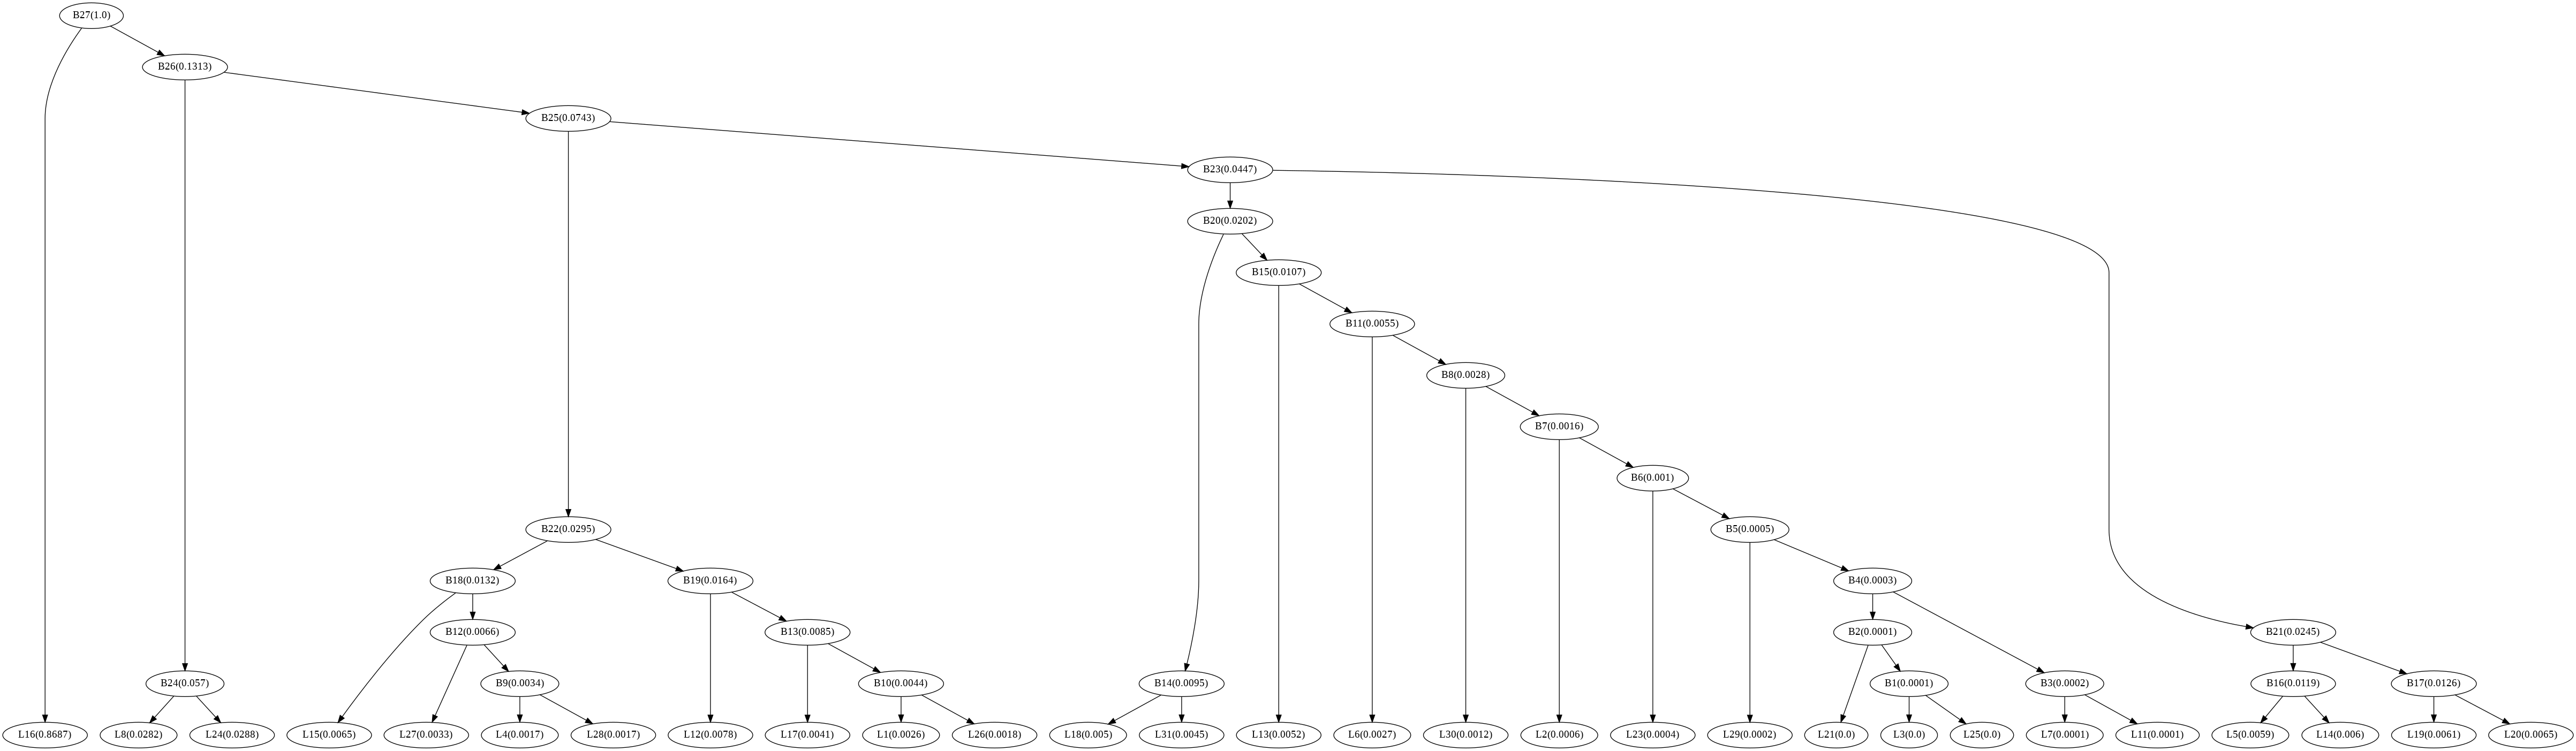

codebook


{'0': 0,
 '100': -8,
 '101': 8,
 '11000': -1,
 '110010': 11,
 '1100110': -12,
 '1100111': 12,
 '11010': -4,
 '110110': 1,
 '1101110': -15,
 '1101111': 10,
 '111000': 2,
 '111001': 15,
 '111010': -3,
 '1110110': -10,
 '11101110': 14,
 '111011110': -14,
 '1110111110': 7,
 '11101111110': 13,
 '1110111111100': 5,
 '11101111111010': -13,
 '11101111111011': 9,
 '1110111111110': -9,
 '1110111111111': -5,
 '111100': -11,
 '111101': -2,
 '111110': 3,
 '111111': 4}

In [5]:
#@title Create Huffman code & Code Book
### create huffman tree 
def create_hufftree(img):
  def get_pro_list(img):
    img = copy(img).flatten()
    pro_list = {}
    _range = range(32) if differential_coding else range(16)
    for i in _range:
      pro_list[str(i)] = (i==img).sum()/img.shape[0]
    return pro_list 
  import matplotlib.pyplot as plt
  pro_list = get_pro_list(img)
  pro_rank = np.argsort(pro_list)
  # create node
  huff_tree = {}
  for i in np.unique(img):
    huff_tree[f'L{i}'] = {'value':pro_list[str(i)],'consider':False}
  for i in range(1,np.unique(img).shape[0]):
    huff_tree[f'B{i}'] = {'value':0,'consider':True}
  # create linkage by huffman
  for i in range(1,np.unique(img).shape[0]):
    pro = np.array([huff_tree[node]['value'] if huff_tree[node]['consider']==False else 2  for node in huff_tree])
    # plt.bar(huff_tree.keys(),pro)
    # # plt.figure(figsize=(20,8))
    # plt.show()
    huff_tree[list(huff_tree.keys())[np.argsort(pro)[0]]]['consider'] = True
    huff_tree[list(huff_tree.keys())[np.argsort(pro)[1]]]['consider'] = True
    huff_tree[list(huff_tree.keys())[np.argsort(pro)[0]]]['parent'] = f'B{i}'
    huff_tree[list(huff_tree.keys())[np.argsort(pro)[1]]]['parent'] = f'B{i}'
    p0 = huff_tree[list(huff_tree.keys())[np.argsort(pro)[0]]]['value']
    p1 = huff_tree[list(huff_tree.keys())[np.argsort(pro)[1]]]['value'] 
    huff_tree[f'B{i}'] = {'value':p0+p1,'consider':False}
  return huff_tree

### get node
def get_max_branch_node(huff_tree):
  return [node for node in huff_tree.keys() if 'parent' not in huff_tree[node].keys()][0]

def get_leaf_node(huff_tree):
  return [string for string in huff_tree.keys() if 'L' in string]

### print tree
def layout(G):
  import matplotlib.image as mpimg
  import matplotlib.pyplot as plt
  import io
  f = io.BytesIO(G.draw(format='png', prog='dot', args=f'-Gdpi=600'))
  fig, ax = plt.subplots(figsize=(15,15))
  im = mpimg.imread(f)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(im)
  plt.show()

def print_tree(huff_tree):
  import pygraphviz as pgv
  tree = pgv.AGraph(directed=True, strict=True)
  for node in huff_tree:
    tree.add_node(node,label=node+'('+str(np.around(huff_tree[node]['value'],decimals=4))+')')
  for node in huff_tree:
    if 'parent' in huff_tree[node]:
      tree.add_edge([huff_tree[node]['parent'],node])
  Leaf_level = tree.add_subgraph(get_leaf_node(huff_tree),rank='same')
  # layout(tree)
  tree.draw('tree.png',prog='dot')
  cv2.imshow(cv2.imread('tree.png'))
  return tree

huff_tree = create_hufftree(img4)
tree = print_tree(huff_tree)
#############################################################################
### tree to code
def find_all(_str, sub):
  start = 0
  re = []
  while True:
    start = _str.find(sub, start)
    if start == -1: 
      return re
    start += len(sub) # use start += 1 to find overlapping matches
    re.append(start)

def find_till(_str, start, end_symbol):
  re = ''
  while start<len(_str):
    start += 1
    if tree_string[start]==end_symbol:
      return re
    else:
      re += tree_string[start]

def next_node(node):
  this_string = node + ' ->'
  next_string = []
  find_index = find_all(tree_string,this_string)
  for index in find_index:
    next_string.append(find_till(tree_string,index,';'))
  return next_string

def node_chain(node,code=''): 
  huff_tree[node]['code'] = code
  next_string = next_node(node)
  for i,string in enumerate(next_string):
    node_chain(string,code+str(i))

def get_code():
  # return [node+':'+huff_tree[node]['code'] for node in huff_tree]
  codebook = {}
  for node in get_leaf_node(huff_tree):
    codebook[huff_tree[node]['code']] = int(node[1:])-16 if differential_coding else int(node[1:])
  return codebook

### create_codebook
def code2node(code):
  for node in huff_tree:
    if huff_tree[node]['code']==code:
      return node

def node2code(node):
  return huff_tree[node]['code']

def get_codebook_node():
  codebook_node = [code2node('')] 
  while(any('B' in code for code in codebook_node)):
    for i in range(len(codebook_node)):
      if 'B' in codebook_node[i]:
        shift = len(codebook_node) - i
        code_tmp = node2code(codebook_node[i])
        codebook_node[i] = 'S'+str(shift)
        codebook_node.append(code2node(code_tmp+'0'))
        codebook_node.append(code2node(code_tmp+'1'))
  return codebook_node[1:]

def codebook_nodeTocodebook_binary(codebook_node):
  codebook_binary = ['']*len(codebook_node)
  for i,code in enumerate(codebook_node):
    if 'S' in code: # S?
      codebook_binary[i] = '1'+bin(int(code[1:]))[2:].zfill(7)+'b'
    else: # L?
      codebook_binary[i] = '0'+bin(int(code[1:]))[2:].zfill(7)+'b'
  return codebook_binary

tree_string = tree.to_string()    
node_chain(node=get_max_branch_node(huff_tree))
codebook = get_code()
codebook_node = get_codebook_node()
codebook_binary = codebook_nodeTocodebook_binary(codebook_node)
print('codebook')
codebook

In [6]:
#@title Huffman (create .asm code)
def _8086ToHuff(img,codebook):
  img2 = np.zeros_like(img,dtype='O')
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      image = img[i,j]-16 if differential_coding else img[i,j]
      img2[i,j] = list(codebook.keys())[list(codebook.values()).index(image)] if image in codebook.values() else list(codebook.keys())[0]
  return img2
  
def HuffToEncode(img,codebook,name):
  # create codebook ...
  encode_re = name + ' \\'
  for i,code in enumerate(codebook):
    if i%5==0:
      encode_re = encode_re + '\ndb   ' + code
    else:
      encode_re = encode_re + ',' + code
  # to hex
  encode_img = ''
  for pixel in img.flatten():
    encode_img += pixel
  for i in range((8-len(encode_img)%8)%8):
    encode_img += '0'
  encode_img = hex(int(encode_img,2))[2:].zfill(len(encode_img)//4)
  # print(encode_img)
  # create data ...
  for i,code in enumerate(encode_img):
    if i%20==0:
      encode_re += '\ndb  '
    if i%2==0:
      encode_re += '0' if code>'9' else ' '
    encode_re += code
    if i%2==1:
      encode_re += 'h,' if i%20!=19 else 'h'
  if encode_re[-1]==',' :
    encode_re = encode_re[:-1] # delete last ','
  return encode_re 

img7 = _8086ToHuff(img4,codebook)
encode = HuffToEncode(img7,codebook_binary,choose)
encode

'CoP \\\ndb   00010000b,10000001b,10000010b,10000011b,00001000b\ndb   00011000b,10000010b,10000011b,10000100b,10000101b\ndb   10000110b,10000111b,00001111b,10000111b,00001100b\ndb   10000111b,10001000b,10001001b,10001010b,10001011b\ndb   00011011b,10001011b,00010001b,10001011b,00010010b\ndb   00011111b,00001101b,10001001b,00000101b,00001110b\ndb   00010011b,00010100b,00000100b,00011100b,00000001b\ndb   00011010b,00000110b,10000001b,00011110b,10000001b\ndb   00000010b,10000001b,00010111b,10000001b,00011101b\ndb   10000001b,10000010b,10000011b,00010101b,10000011b\ndb   00000111b,00001011b,00000011b,00011001b\ndb  0c8h, 00h, 00h, 00h, 00h, 00h, 00h, 00h, 00h, 00h\ndb   00h, 00h, 00h, 00h, 00h, 00h, 00h, 00h, 7eh,0dch\ndb  0e4h,0d7h, 8eh, 4dh,0c7h, 2dh,0ceh, 5bh, 81h,0dfh\ndb  0dfh, 7fh, 80h, 00h, 00h, 07h,0f7h, 8eh, 80h, 00h\ndb   00h, 00h, 00h, 00h, 00h, 00h, 00h, 00h, 00h, 00h\ndb   00h, 00h, 00h, 00h, 00h, 07h,0edh,0ceh, 4dh,0c0h\ndb   1ch,0b7h, 39h, 6eh, 39h, 6eh, 00h, 00h, 00h, 0fh\n

In [7]:
#@title 複製上面程式碼排版後應變成這樣：
print(encode[:1000])
print('...')

CoP \
db   00010000b,10000001b,10000010b,10000011b,00001000b
db   00011000b,10000010b,10000011b,10000100b,10000101b
db   10000110b,10000111b,00001111b,10000111b,00001100b
db   10000111b,10001000b,10001001b,10001010b,10001011b
db   00011011b,10001011b,00010001b,10001011b,00010010b
db   00011111b,00001101b,10001001b,00000101b,00001110b
db   00010011b,00010100b,00000100b,00011100b,00000001b
db   00011010b,00000110b,10000001b,00011110b,10000001b
db   00000010b,10000001b,00010111b,10000001b,00011101b
db   10000001b,10000010b,10000011b,00010101b,10000011b
db   00000111b,00001011b,00000011b,00011001b
db  0c8h, 00h, 00h, 00h, 00h, 00h, 00h, 00h, 00h, 00h
db   00h, 00h, 00h, 00h, 00h, 00h, 00h, 00h, 7eh,0dch
db  0e4h,0d7h, 8eh, 4dh,0c7h, 2dh,0ceh, 5bh, 81h,0dfh
db  0dfh, 7fh, 80h, 00h, 00h, 07h,0f7h, 8eh, 80h, 00h
db   00h, 00h, 00h, 00h, 00h, 00h, 00h, 00h, 00h, 00h
db   00h, 00h, 00h, 00h, 00h, 07h,0edh,0ceh, 4dh,0c0h
db   1ch,0b7h, 39h, 6eh, 39h, 6eh, 00h, 00h, 00h, 0fh
db  0dbh,0ddh, 00h, 0

In [8]:
#@title 結果(壓縮比)

print('行數節省:',int(img4.shape[0]*img4.shape[1]/10),'->',encode.count('\n'),'line')
print('壓縮比:',(img4.shape[0]*img4.shape[1])/(10*encode.count('\n')))

行數節省: 2200 -> 422 line
壓縮比: 5.213270142180095


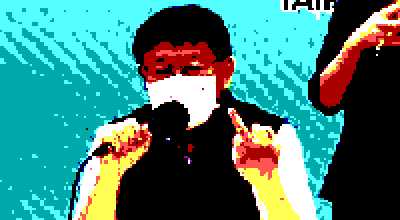

In [9]:
#@title 驗證
def codebook_chain(codebook_binary,codebook,code='',i=0):
  if codebook_binary[i][0] == '1': #shift
    next_i = (i)+int(codebook_binary[i][1:-1],2)
    codebook_chain(codebook_binary,codebook,code+'0',next_i)
  else: #Leaf
    codebook[code+'0'] = int(codebook_binary[i][1:-1],2) - (16 if differential_coding else 0) 
  if codebook_binary[i+1][0] == '1': #shift
    next_i = (i+1)+int(codebook_binary[i+1][1:-1],2)
    codebook_chain(codebook_binary,codebook,code+'1',next_i)
  else: #Leaf
    codebook[code+'1'] = int(codebook_binary[i+1][1:-1],2) - (16 if differential_coding else 0)

def codebook_binaryTocodebook_node(codebook_binary):
  codebook = {}
  codebook_chain(codebook_binary,codebook)
  return codebook

def HuffTo8086(img):
  img2 = np.zeros_like(img,dtype=int)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      img2[i,j] = codebook[img[i,j]]
  return img2

def EncodeTo8086(encode,shape):
  img = np.array([],dtype=int)
  point = encode.find('\\')
  code_buffer = ''
  while True:
    point = encode.find('h',point+1)
    code = encode[point-2:point]
    if point == -1:
      if differential_coding:
        for i in range(1,img.shape[0]):
          img[i] = img[i-1] + img[i]
      return img[:shape[0]*shape[1]].reshape(shape).astype(int)###-1
    else:
      code_buffer = code_buffer + bin(int(code,16))[2:].zfill(8)
      code_buffer = get_code_from_codebook(code_buffer) 
      img = np.append(img, code_buffer[:-1])
      code_buffer = code_buffer[-1]

def get_code_from_codebook(code):
  for i in range(1,len(code)+1):
    if code[:i] in codebook:
      re = get_code_from_codebook(code[i:])
      return [codebook[code[:i]]]+get_code_from_codebook(code[i:])
  return [code]

codebook = codebook_binaryTocodebook_node(codebook_binary)
shape = img4.shape
img8 = _8086toC16(EncodeTo8086(encode,shape))
show([img8])

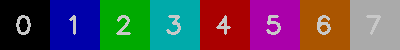

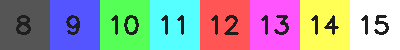

In [10]:
#@title 8086色碼表
true_palette = np.array([
  [0,0,0],
  [170,0,0],
  [0,170,0],
  [170,170,0],
  [0,0,170],
  [170,0,170],
  [0,85,170], #[0,170,170],
  [170,170,170],
  [85,85,85],
  [255,85,85],
  [85,255,85],
  [255,255,85],
  [85,85,255],
  [255,85,255],
  [85,255,255],
  [255,255,255],
])
img_tmp = np.empty([50,0,3])
for i in range(8):
  img_tmp1 = np.tile(true_palette[i],[50,50,1])
  img_tmp1 = cv2.putText(img_tmp1, str(i), (15, 33), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (200,200,200), 2).get()
  img_tmp = np.hstack([img_tmp,img_tmp1])
cv2.imshow(img_tmp)
img_tmp = np.empty([50,0,3])
for i in range(8,16):
  img_tmp1 = np.tile(true_palette[i],[50,50,1])
  img_tmp1 = cv2.putText(img_tmp1, str(i), (15-8*(len(str(i))-1), 33), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (30,30,30), 2).get()
  img_tmp = np.hstack([img_tmp,img_tmp1])
cv2.imshow(img_tmp)  